In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from gpytorch.kernels import RBFKernel
from gpytorch.priors import NormalPrior

from mobius import Planner, SequenceGA
from mobius import ProteinEmbedding
from mobius import InverseFolding
from mobius import GPLLModel, ExpectedImprovement
from mobius.utils import generate_biopolymer_design_protocol_from_probabilities
from mobius import homolog_scanning
from mobius import convert_FASTA_to_HELM, convert_HELM_to_FASTA

## GB1 dataset

Citation: Adaptation in protein fitness landscapes is facilitated by indirect paths; Wu et al.; 2016; http://dx.doi.org/10.7554/eLife.16965.001

In [3]:
df_exp = pd.read_excel('elife-16965-supp1-v4.xlsx')
df_imputated = pd.read_excel('elife-16965-supp2-v4.xlsx')

/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
df_imputated = df_imputated.rename(columns={"Imputed fitness": "Fitness"})
df = pd.concat([df_exp[['Variants', 'Fitness']], df_imputated])

In [5]:
sequences = []
wt_sequence = list('MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE')

for variant in df['Variants'].values:
    wt_sequence[38] = variant[0]
    wt_sequence[39] = variant[1]
    wt_sequence[40] = variant[2]
    wt_sequence[53] = variant[3]

    sequences.append(''.join(wt_sequence))

df['Sequences'] = sequences
df.to_csv('GB1_dataset.csv', index=False)

## Initialize GB1 oracle

In [6]:
class GB1Scorer:
    
    def __init__(self, sequences, values):
        if len(sequences) != len(values):
            raise ValueError(f'Different numbers of sequences and values ({len(sequences)} != {len(values)})')

        self._data = {s: v for s, v in zip(sequences, values)}

    def score(self, sequences):
        if not isinstance(sequences, (list, tuple, np.ndarray)):
            sequences = [sequences]
        
        return np.array([self._data[s] for s in sequences])


In [7]:
df = pd.read_csv('GB1_dataset.csv')
sequences = df['Sequences'].values
fitness = df['Fitness'].values

gb1 = GB1Scorer(sequences, fitness)
gb1.score('MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE')

array([1.])

## Some plots...

In [28]:
print(np.min(fitness))
print(np.max(fitness))

0.0
9.9130883273888


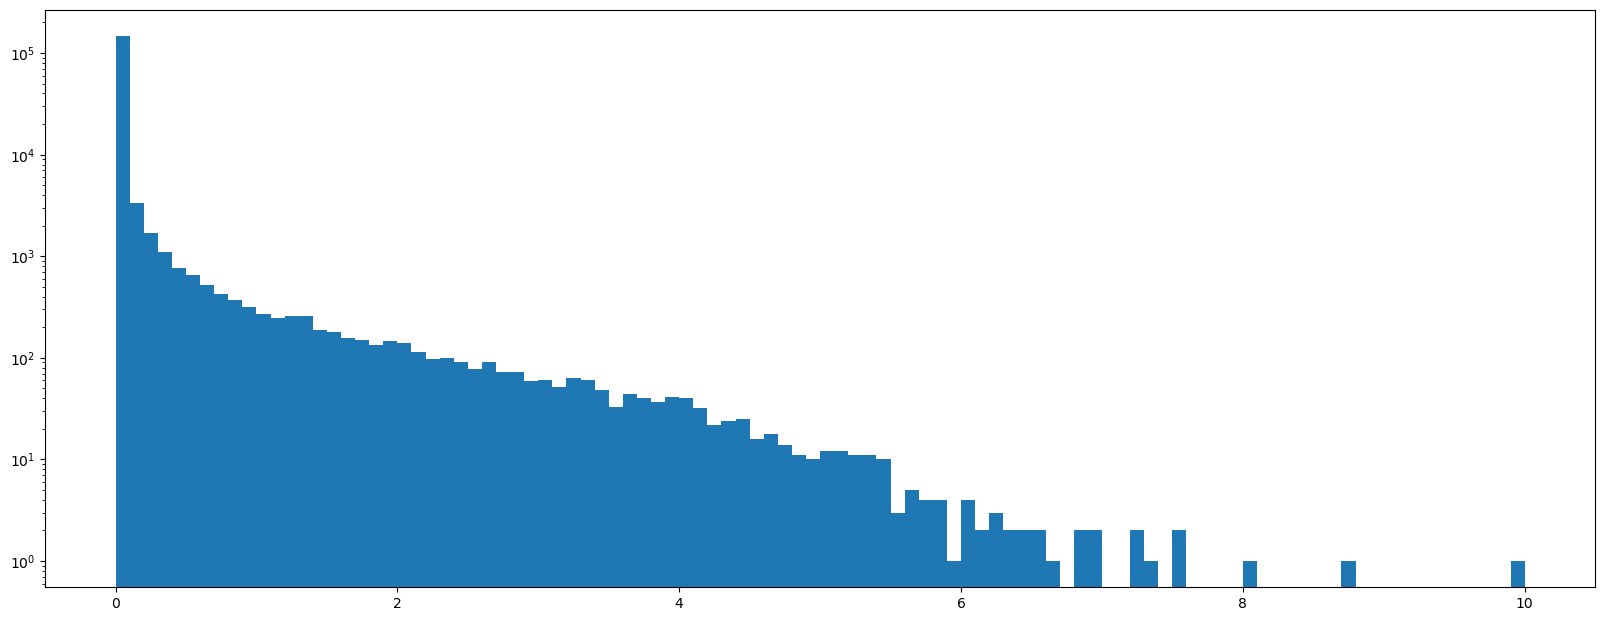

In [33]:
fig, ax = plt.subplots(figsize=(20, 7.5))
ax.hist(fitness, bins=np.linspace(0, 10, 101), log=True)
#ax.set_ylim([-0.1, 500])

plt.show()

## Run Bayesian Optimization

### With ESM-1b only

In [34]:
# Load protein language model
plm = ProteinEmbedding(pretrained_model_name='esm1b_t33_650M_UR50S', embedding_type='avg')

In [35]:
yaml_content = """
    design:
      monomers:
        default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
      biopolymers:
        - name: GB1
          starting_residue: 1
          length: 56
          positions:
            39: default
            40: default
            41: default
            54: default
    """
    
with open('design_protocol_gb1.yaml', 'w') as f:
    f.write(yaml_content)

In [36]:
# Load surrogate model
gpmodel = GPLLModel(kernel=RBFKernel(), pretrained_model=plm, noise_prior=NormalPrior(0, 1))
ei = ExpectedImprovement(gpmodel, maximize=True)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol_gb1.yaml')
ps = Planner(ei, optimizer)

In [37]:
lead_protein = convert_FASTA_to_HELM('MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE')[0]

seed_library = [lead_protein]
positions = {'PEPTIDE1': [39, 40, 41, 54]}

for seq in homolog_scanning(lead_protein, positions=positions):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of protein allowed.')
        break

seed_library = convert_HELM_to_FASTA(seed_library)
scores_seed_library = gb1.score(seed_library)

In [38]:
sequences = seed_library.copy()
scores = scores_seed_library.copy()
        
# Store data for later analysis
data = [(0, p, s) for p, s in zip(sequences, scores)]
        
for i in range(5):
    suggested_sequences, _ = ps.recommand(sequences, scores.reshape(-1, 1), batch_size=96)
    scores_suggested_sequences = gb1.score(suggested_sequences)
        
    sequences = np.concatenate([sequences, suggested_sequences])
    scores = np.concatenate((scores, scores_suggested_sequences), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_sequences, scores_suggested_sequences)])
        
    best_seq = sequences[np.argmax(scores)]
    best_score = np.max(scores)
    min_score = np.min(scores_suggested_sequences)
    mean_score = np.mean(scores_suggested_sequences)
    print(f'Best GB1 found so far: {best_seq} / {best_score:.3f} (min: {min_score:.3f}, mean: {mean_score:.3f}, max: {best_score:.3f})')
    print('')
    
    df = pd.DataFrame(data=data, columns=('iter', 'sequence', 'exp_value'))
    df.to_csv('results_gb1_homolog.csv', index=False)


Fitting GPLLM model (cuda): 14step [00:15,  1.13s/step, loss=1.02]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  7.15435665664993881 |  3.89803670068332009 | MQYKLILNGKTLKGETTT....VWGEWTYDDATKTFTVTE
     2 |      500 | -5.4890792508424E-04 | -4.7858192303212E-02 | MQYKLILNGKTLKGETTT....IYGEWTYDDATKTFTVTE
     3 |     1000 | -9.8040651379193E-04 | -6.3728497800166E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     4 |     1500 | -1.2202246562406E-03 | -6.3728497800166E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     5 |     2000 | -1.4845849976290E-03 | -6.3728497800166E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     6 |     2500 | -1.7738633970282E-03 | -6.3728497800166E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     7 |     3000 | -1.9960620675125E-03 | -6.3728497800166E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     8 |     3500 | -2.1202157423563E-03 | -6.3728497800166E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     9 |     4000 | -2.2032741551248E

Fitting GPLLM model (cuda): 11step [00:54,  4.93s/step, loss=1.26]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.0358340832886E+01 |  5.77203220933999983 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     2 |      500 | -4.5434898414752E-05 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     3 |     1000 | -8.1294941781521E-05 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     4 |     1500 | -1.5636922007626E-04 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     5 |     2000 | -2.5661998078577E-04 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     6 |     2500 | -3.3898723707837E-04 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     7 |     3000 | -4.1032354786453E-04 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     8 |     3500 | -4.6445791492326E-04 | -8.0754850842790E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     9 |     4000 | -5.0173388058402E

Fitting GPLLM model (cuda): 16step [00:49,  3.08s/step, loss=1.2]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.0269218537592E+01 |  5.77203220933999983 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     2 |      500 | -2.1548256152679E-06 | -8.9629384173074E-05 | MQYKLILNGKTLKGETTT....LWGEWTYDDATKTFTGTE
     3 |     1000 | -9.8634805228739E-06 | -5.7750539360324E-04 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     4 |     1500 | -2.6077173119337E-05 | -7.1319230768473E-04 | MQYKLILNGKTLKGETTT....VYCEWTYDDATKTFTGTE
     5 |     2000 | -4.7637009444651E-05 | -7.1319230768473E-04 | MQYKLILNGKTLKGETTT....VYCEWTYDDATKTFTGTE
     6 |     2500 | -7.9541313177828E-05 | -1.3125923215387E-03 | MQYKLILNGKTLKGETTT....LYCEWTYDDATKTFTGTE
     7 |     3000 | -1.0751927049454E-04 | -1.3125923215387E-03 | MQYKLILNGKTLKGETTT....LYCEWTYDDATKTFTGTE
     8 |     3500 | -1.2944904269400E-04 | -1.3125923215387E-03 | MQYKLILNGKTLKGETTT....LYCEWTYDDATKTFTGTE
     9 |     4000 | -1.3986974683751E

Fitting GPLLM model (cuda): 17step [01:58,  6.94s/step, loss=1.23]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.0107880084476E+01 |  5.77203220933999983 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     2 |      500 | -4.4082553555864E-05 | -2.8222104587430E-03 | MQYKLILNGKTLKGETTT....YWFEWTYDDATKTFTGTE
     3 |     1000 | -1.1531358567019E-04 | -1.7885506554139E-02 | MQYKLILNGKTLKGETTT....LWCEWTYDDATKTFTGTE
     4 |     1500 | -2.9281294896485E-04 | -2.7174249713992E-02 | MQYKLILNGKTLKGETTT....WWFEWTYDDATKTFTGTE
     5 |     2000 | -4.2390882097764E-04 | -2.7174249713992E-02 | MQYKLILNGKTLKGETTT....WWFEWTYDDATKTFTGTE
     6 |     2500 | -5.7242254640993E-04 | -2.7174249713992E-02 | MQYKLILNGKTLKGETTT....WWFEWTYDDATKTFTGTE
     7 |     3000 | -7.1565917589830E-04 | -2.7174249713992E-02 | MQYKLILNGKTLKGETTT....WWFEWTYDDATKTFTGTE
     8 |     3500 | -8.3004664443381E-04 | -2.7174249713992E-02 | MQYKLILNGKTLKGETTT....WWFEWTYDDATKTFTGTE
     9 |     4000 | -8.9135171823420E

Fitting GPLLM model (cuda): 15step [02:43, 10.91s/step, loss=1.24]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.3260580700681E+01 |  7.31265639681999957 | MQYKLILNGKTLKGETTT....FWLEWTYDDATKTFTGTE
     2 |      500 | -1.7630015076716E-06 | -4.9342076800113E-04 | MQYKLILNGKTLKGETTT....WKFEWTYDDATKTFTGTE
     3 |     1000 | -1.3053133818884E-05 | -4.8662886842484E-03 | MQYKLILNGKTLKGETTT....FWLEWTYDDATKTFTGTE
     4 |     1500 | -4.8513001363540E-05 | -1.6170238769609E-02 | MQYKLILNGKTLKGETTT....WWLEWTYDDATKTFTGTE
     5 |     2000 | -5.0579937236386E-05 | -1.6170238769609E-02 | MQYKLILNGKTLKGETTT....WWLEWTYDDATKTFTGTE
     6 |     2500 | -5.4409363830808E-05 | -1.6170238769609E-02 | MQYKLILNGKTLKGETTT....WWLEWTYDDATKTFTGTE
     7 |     3000 | -5.5089500578718E-05 | -1.6170238769609E-02 | MQYKLILNGKTLKGETTT....WWLEWTYDDATKTFTGTE
     8 |     3500 | -5.5290096238358E-05 | -1.6170238769609E-02 | MQYKLILNGKTLKGETTT....WWLEWTYDDATKTFTGTE
     9 |     4000 | -5.5341939276409E

### With ESM-1b and ESM-IF1 (T=0.5)

In [39]:
# Load protein language model
plm = ProteinEmbedding(pretrained_model_name='esm1b_t33_650M_UR50S', embedding_type='avg')

In [40]:
# Get probabilities from structure model
iv = InverseFolding()
probabilities = iv.get_probabilities_from_structure('2gi9.pdb', target_chainid='A', temperature=0.5)
monomers = iv.vocab

# Fix positions involved in the fluorophore activity
wt_seq = 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
positions = [39, 40, 41, 54]
fixed_positions = {}

for i, aa in enumerate(wt_seq):
    if not i + 1 in positions:
        fixed_positions[i + 1] = aa

with open('design_protocol_gb1_probabilities.yaml', 'w') as w:
    data = generate_biopolymer_design_protocol_from_probabilities(probabilities, monomers, fixed_positions=fixed_positions)
    yaml.dump(data, w, sort_keys=False)

/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mobius-ubuntu/lib/python3.11/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [41]:
# Load surrogate model
gpmodel = GPLLModel(kernel=RBFKernel(), pretrained_model=plm, noise_prior=NormalPrior(0, 1))
ei = ExpectedImprovement(gpmodel, maximize=True)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol_gb1_probabilities.yaml')
ps = Planner(ei, optimizer)

In [42]:
lead_protein = convert_FASTA_to_HELM('MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE')[0]

seed_library = [lead_protein]
positions = {'PEPTIDE1': [39, 40, 41, 54]}

for seq in homolog_scanning(lead_protein, positions=positions):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of protein allowed.')
        break

seed_library = convert_HELM_to_FASTA(seed_library)
scores_seed_library = gb1.score(seed_library)

In [43]:
sequences = seed_library.copy()
scores = scores_seed_library.copy()
        
# Store data for later analysis
data = [(0, p, s) for p, s in zip(sequences, scores)]
        
for i in range(5):
    suggested_sequences, _ = ps.recommand(sequences, scores.reshape(-1, 1), batch_size=96)
    scores_suggested_sequences = gb1.score(suggested_sequences)
        
    sequences = np.concatenate([sequences, suggested_sequences])
    scores = np.concatenate((scores, scores_suggested_sequences), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_sequences, scores_suggested_sequences)])
        
    best_seq = sequences[np.argmax(scores)]
    best_score = np.max(scores)
    min_score = np.min(scores_suggested_sequences)
    mean_score = np.mean(scores_suggested_sequences)
    print(f'Best GB1 found so far: {best_seq} / {best_score:.3f} (min: {min_score:.3f}, mean: {mean_score:.3f}, max: {best_score:.3f})')
    print('')
    
    df = pd.DataFrame(data=data, columns=('iter', 'sequence', 'exp_value'))
    df.to_csv('results_gb1_homolog_esm-if1.csv', index=False)


Fitting GPLLM model (cuda): 14step [00:16,  1.15s/step, loss=1.02]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  7.15435665664993881 |  3.89803670068332009 | MQYKLILNGKTLKGETTT....VWGEWTYDDATKTFTVTE
     2 |      500 | -5.3339713128006E-04 | -4.7858195727885E-02 | MQYKLILNGKTLKGETTT....IYGEWTYDDATKTFTVTE
     3 |     1000 | -9.5084000093757E-04 | -6.3728547093237E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     4 |     1500 | -1.1663151690592E-03 | -6.3728547093237E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     5 |     2000 | -1.4781618335290E-03 | -6.3728547093237E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     6 |     2500 | -1.6558808208940E-03 | -6.3728547093237E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     7 |     3000 | -1.7973118277524E-03 | -6.3728547093237E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     8 |     3500 | -1.8959649733395E-03 | -6.3728547093237E-02 | MQYKLILNGKTLKGETTT....VYGEWTYDDATKTFTVTE
     9 |     4000 | -1.9996499133466E

Fitting GPLLM model (cuda): 11step [00:19,  1.82s/step, loss=1.26]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.0411398689636E+01 |  5.77203220933999983 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     2 |      500 | -4.6405833316381E-05 | -3.0533656576523E-03 | MQYKLILNGKTLKGETTT....FWGEWTYDDATKTFTFTE
     3 |     1000 | -1.6206212542011E-04 | -1.2999269784332E-02 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     4 |     1500 | -3.0681237879490E-04 | -1.2999269784332E-02 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     5 |     2000 | -5.0595525598348E-04 | -1.2999269784332E-02 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     6 |     2500 | -6.4054309219427E-04 | -1.2999269784332E-02 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     7 |     3000 | -6.9276497381340E-04 | -1.2999269784332E-02 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     8 |     3500 | -7.2242942753764E-04 | -1.2999269784332E-02 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTWTE
     9 |     4000 | -7.3764078478724E

Fitting GPLLM model (cuda): 11step [00:41,  3.80s/step, loss=1.19]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.0373018931908E+01 |  5.77203220933999983 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     2 |      500 | -8.8218575938857E-07 | -1.0299009750796E-04 | MQYKLILNGKTLKGETTT....TYGEWTYDDATKTFTCTE
     3 |     1000 | -3.7627246546606E-06 | -2.8842208775472E-04 | MQYKLILNGKTLKGETTT....FYGEWTYDDATKTFTCTE
     4 |     1500 | -1.0490789278710E-05 | -1.0459754492522E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     5 |     2000 | -1.6338334320422E-05 | -1.0459754492522E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     6 |     2500 | -2.1452949250834E-05 | -1.0459754492522E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     7 |     3000 | -2.6654403851153E-05 | -1.0459754492522E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     8 |     3500 | -3.0614365472894E-05 | -1.0459754492522E-03 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     9 |     4000 | -3.3218877982751E

Fitting GPLLM model (cuda): 14step [01:40,  7.18s/step, loss=1.24]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.0311340966618E+01 |  5.77203220933999983 | MQYKLILNGKTLKGETTT....IWGEWTYDDATKTFTFTE
     2 |      500 | -9.8627169848210E-07 | -8.6810815067428E-05 | MQYKLILNGKTLKGETTT....LRCEWTYDDATKTFTGTE
     3 |     1000 | -9.3558381645971E-06 | -1.2629101543135E-03 | MQYKLILNGKTLKGETTT....THCEWTYDDATKTFTATE
     4 |     1500 | -1.3868806297552E-05 | -1.2629101543135E-03 | MQYKLILNGKTLKGETTT....THCEWTYDDATKTFTATE
     5 |     2000 | -1.7545127476574E-05 | -1.2629101543135E-03 | MQYKLILNGKTLKGETTT....THCEWTYDDATKTFTATE
     6 |     2500 | -2.0235069350704E-05 | -1.2629101543135E-03 | MQYKLILNGKTLKGETTT....THCEWTYDDATKTFTATE
     7 |     3000 | -2.2307056071480E-05 | -1.2629101543135E-03 | MQYKLILNGKTLKGETTT....THCEWTYDDATKTFTATE
     8 |     3500 | -2.3852981387018E-05 | -1.2629101543135E-03 | MQYKLILNGKTLKGETTT....THCEWTYDDATKTFTATE
     9 |     4000 | -2.5314587857969E

Fitting GPLLM model (cuda): 13step [01:38,  7.55s/step, loss=1.38]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  1.8517001510241E+01 |  9.91308832738880064 | MQYKLILNGKTLKGETTT....AHCEWTYDDATKTFTATE
     2 |      500 | -7.0897978823014E-13 | -2.4700570655305E-10 | MQYKLILNGKTLKGETTT....WWCEWTYDDATKTFTGTE
     3 |     1000 | -1.9250064671620E-12 | -4.0064413493086E-10 | MQYKLILNGKTLKGETTT....ANCEWTYDDATKTFTATE
     4 |     1500 | -1.7841975641506E-11 | -4.2092131042628E-09 | MQYKLILNGKTLKGETTT....ASCEWTYDDATKTFTATE
     5 |     2000 | -2.2801034233812E-11 | -4.2092131042628E-09 | MQYKLILNGKTLKGETTT....ASCEWTYDDATKTFTATE
     6 |     2500 | -2.9552371732440E-11 | -4.2092131042628E-09 | MQYKLILNGKTLKGETTT....ASCEWTYDDATKTFTATE
     7 |     3000 | -3.0375144728455E-11 | -4.2092131042628E-09 | MQYKLILNGKTLKGETTT....ASCEWTYDDATKTFTATE
     8 |     3500 | -3.1855525354993E-11 | -4.2092131042628E-09 | MQYKLILNGKTLKGETTT....ASCEWTYDDATKTFTATE
     9 |     4000 | -3.2780507190189E

## Comparison

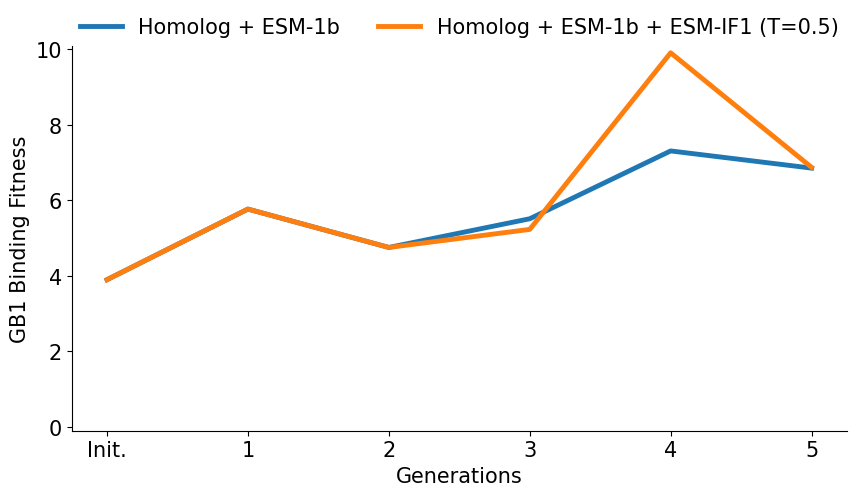

In [44]:
methods = ['gb1_homolog', 'gb1_homolog_esm-if1']
method_renaming = {'gb1_homolog': 'Homolog + ESM-1b', 'gb1_homolog_esm-if1': 'Homolog + ESM-1b + ESM-IF1 (T=0.5)'}

dfs = []

for method in methods:
    df = pd.read_csv(f'results_{method}.csv')
    df['method'] = method_renaming[method]
    maxs = df.loc[df.groupby(by=['iter'])['exp_value'].idxmax()]
    dfs.append(maxs)

dfs = pd.concat(dfs).reset_index()

dfs['iter'] = dfs['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

fig, axarr = plt.subplots(figsize=(10, 5))
sns.lineplot(x='iter', y='exp_value', hue='method', data=dfs, ax=axarr, linewidth=3.5)

axarr.legend(loc='upper right', fontsize=15, frameon=False)
axarr.set_ylim([-0.1, 10.1])
axarr.set_xlabel("Generations", fontsize=15)
axarr.set_ylabel("GB1 Binding Fitness", fontsize=15)
axarr.xaxis.set_tick_params(labelsize=15)
axarr.yaxis.set_tick_params(labelsize=15)

axarr.get_legend().remove()
axarr.legend(bbox_to_anchor=(0., 1., 1., 0.2), loc=3, ncol=2, mode="expand", borderaxespad=0, fontsize=15, frameon=False)

sns.despine()

plt.show()

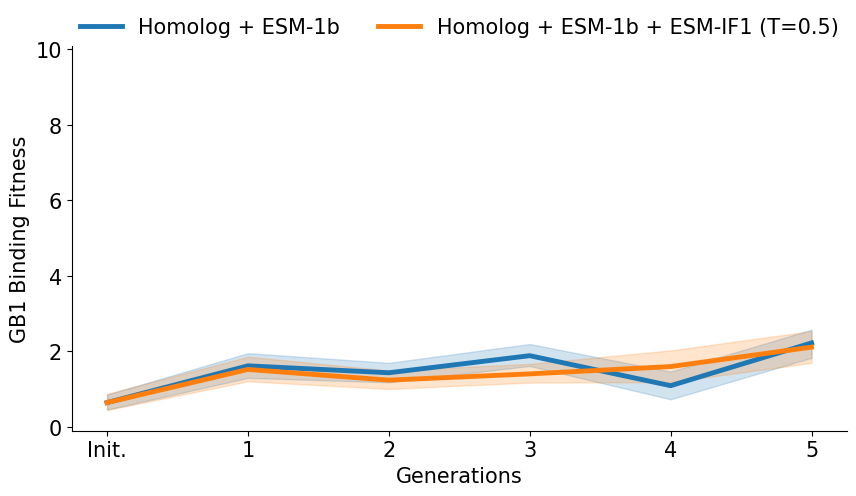

In [45]:
methods = ['gb1_homolog', 'gb1_homolog_esm-if1']
method_renaming = {'gb1_homolog': 'Homolog + ESM-1b', 'gb1_homolog_esm-if1': 'Homolog + ESM-1b + ESM-IF1 (T=0.5)'}

dfs = []

for method in methods:
    df = pd.read_csv(f'results_{method}.csv')
    df['method'] = method_renaming[method]
    dfs.append(df)

dfs = pd.concat(dfs).reset_index()

dfs['iter'] = dfs['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

fig, axarr = plt.subplots(figsize=(10, 5))
sns.lineplot(x='iter', y='exp_value', hue='method', data=dfs, ax=axarr, linewidth=3.5)

axarr.legend(loc='upper right', fontsize=15, frameon=False)
axarr.set_ylim([-0.1, 10.1])
axarr.set_xlabel("Generations", fontsize=15)
axarr.set_ylabel("GB1 Binding Fitness", fontsize=15)
axarr.xaxis.set_tick_params(labelsize=15)
axarr.yaxis.set_tick_params(labelsize=15)

axarr.get_legend().remove()
axarr.legend(bbox_to_anchor=(0., 1., 1., 0.2), loc=3, ncol=2, mode="expand", borderaxespad=0, fontsize=15, frameon=False)

sns.despine()

plt.show()